# Estimating the Circulation and Climate of the Ocean (ECCO) Analysis

Daily, 1 deg, 2005-2017 (Argo era)

## From the ECCO website on why ECCO versus other renanalyses:
ECCO state estimates share many similarities with conventional ocean reanalyses but differ in several key respects. Both are ocean reconstructions that use observational data to fit an ocean model to the data so that the model agrees with the data in a statistical sense. Ocean reanalyses are constructed by directly adjusting the ocean model’s state to reduce its misfit to the data. Furthermore, information contained in the data is only explored forward in time. In contrast, ECCO state estimates are constructed by identifying a set of ocean model initial conditions, parameters, and atmospheric boundary conditions such that a free-running simulation of the ocean model reproduces the observations as a result of the governing equations of motion. These equations also provide a means for propagating information contained in the data back in time (“upstream” of when/where observations have been made). Therefore, while both ocean reanalyses and ECCO state estimates reproduce observations of ocean variability, only ECCO state estimates provide an explanation for the underlying physical causes and mechanisms responsible for bringing them into existence (e.g., Stammer et al. 2017).

## Imports

In [1]:
import sys
import datetime
sys.path.append('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/ECCOv4-py')
import ecco_v4_py as ecco
from ecco_download import *
import numpy as np
import pandas as pd
from os.path import join,expanduser
import xarray as xr
import matplotlib.pyplot as plt
from getpass import getpass
from http.cookiejar import CookieJar
from pathlib import Path
from netrc import netrc
from cartopy.mpl.geoaxes import GeoAxes
import cartopy
import geopandas
from scipy.stats import linregress
from mpl_toolkits.axes_grid1 import AxesGrid
# library to download files
from urllib import request
from scipy import signal
import glob
import xgcm
import scipy.signal as sps
import scipy.linalg as spl
from xgcm import Grid
import cmocean.cm as cmo
from dask.diagnostics import ProgressBar
user_home_dir = expanduser('~')
_netrc = join(user_home_dir)


################################################################################################
##                         These are all from the ECCO python tutorial                         #
################################################################################################
# not pretty but it works
def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        username, _, password = netrc(file=_netrc).authenticators(url)

    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

################################################################################################
##                                         Constants                                          ##
################################################################################################
# Seawater density (kg/m^3)
rhoconst = 1029     ## needed to convert surface mass fluxes to volume fluxes
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0


download_root_dir = Path('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/')





################################################################################################
## For detrending the xarray dataset, from: https://xrft.readthedocs.io/en/latest/_modules/xrft/detrend.html

def detrend(da, dim, detrend_type="constant"):
    """
    Detrend a DataArray

    Parameters
    ----------
    da : xarray.DataArray
        The data to detrend
    dim : str or list
        Dimensions along which to apply detrend.
        Can be either one dimension or a list with two dimensions.
        Higher-dimensional detrending is not supported.
        If dask data are passed, the data must be chunked along dim.
    detrend_type : {'constant', 'linear'}
        If ``constant``, a constant offset will be removed from each dim.
        If ``linear``, a linear least-squares fit will be estimated and removed
        from the data.

    Returns
    -------
    da : xarray.DataArray
        The detrended data.

    Notes
    -----
    This function will act lazily in the presence of dask arrays on the
    input.
    """

    if dim is None:
        dim = list(da.dims)
    else:
        if isinstance(dim, str):
            dim = [dim]

    if detrend_type not in ["constant", "linear", None]:
        raise NotImplementedError(
            "%s is not a valid detrending option. Valid "
            "options are: 'constant','linear', or None." % detrend_type
        )

    if detrend_type is None:
        return da
    elif detrend_type == "constant":
        return da - da.mean(dim=dim)
    elif detrend_type == "linear":
        data = da.data
        axis_num = [da.get_axis_num(d) for d in dim]
        chunks = getattr(data, "chunks", None)
        if chunks:
            axis_chunks = [data.chunks[a] for a in axis_num]
            if not all([len(ac) == 1 for ac in axis_chunks]):
                raise ValueError("Contiguous chunks required for detrending.")
        if len(dim) == 1:
            dt = xr.apply_ufunc(
                sps.detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
        elif len(dim) == 2:
            dt = xr.apply_ufunc(
                _detrend_2d_ufunc,
                da,
                input_core_dims=[dim],
                output_core_dims=[dim],
                output_dtypes=[da.dtype],
                vectorize=True,
                dask="parallelized",
            )
        else:  # pragma: no cover
            raise NotImplementedError(
                "Only 1D and 2D detrending are implemented so far."
            )

    return dt


################################################################################################
## For the lowpass filter
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y


## Download data

### Can only download 2000 files at a time so need to break into chunks

In [12]:
start_date = '2005-01-01'
#end_date = '2010-06-22'

#start_date = '2010-06-22'
#end_date = '2015-12-12'

#start_date = '2015-12-12'
end_date = '2017-12-31'

tile_isel = [10,12,1]
## Subsetting to tiles 10 and 11 now takes ~a day to download and is ~160 GB

In [3]:
# ## Download SSH
# ecco_podaac_download_subset(ShortName='ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4',
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)


In [4]:
# ## Download temp/salinity
# ecco_podaac_download_subset(ShortName='ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4',
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [5]:
# ## Download FW flux
# ecco_podaac_download_subset(ShortName='ECCO_L4_FRESH_FLUX_LLC0090GRID_DAILY_V4R4',
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [6]:
# # Download salt flux
# ecco_podaac_download_subset(ShortName="ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [7]:
# # Download temperature flux
# ecco_podaac_download_subset(ShortName="ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [8]:
# # Download heat flux
# ecco_podaac_download_subset(ShortName="ECCO_L4_HEAT_FLUX_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [9]:
# # Download volume flux
# ecco_podaac_download_subset(ShortName="ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [10]:
# # Download bolus
# ecco_podaac_download_subset(ShortName="ECCO_L4_OCEAN_BOLUS_STREAMFUNCTION_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

In [14]:
# # Download MLD
# ecco_podaac_download_subset(ShortName="ECCO_L4_MIXED_LAYER_DEPTH_LLC0090GRID_DAILY_V4R4",
#                             StartDate=start_date,
#                             EndDate=end_date,
#                             download_root_dir=download_root_dir,
#                             n_workers=6,
#                             force_redownload=False,
#                             include_latlon_coords=False, 
#                             tile_isel=tile_isel)

## Load data

This takes ~12 minutes

I don't know why this gets mad when I run it the first time and then it is fine if I immediately rerun the cell.

In [ ]:
%%time
fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_FRESH_FLUX_LLC0090GRID_DAILY_V4R4/*.nc']))
fresh_flux = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_DAILY_V4R4/*.nc']))
salt_flux = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_HEAT_FLUX_LLC0090GRID_DAILY_V4R4/*.nc']))
heat_flux = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_DAILY_V4R4/*.nc']))
temp_flux = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_DAILY_V4R4/*.nc']))
vol_flux = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_OCEAN_BOLUS_STREAMFUNCTION_LLC0090GRID_DAILY_V4R4/*.nc']))
bolus = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4/*.nc']))
etan = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

fnames = glob.glob(''.join([str(download_root_dir),'/ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4/*.nc']))
ts = xr.open_mfdataset(fnames, parallel=True, data_vars='minimal', coords='minimal', compat='override')

## Create one dataset with all the variables we need

This takes ~2 minutes

In [33]:
%%time
ds = xr.merge([fresh_flux[['SFLUX','oceFWflx']],
                 salt_flux[['oceSPtnd','ADVx_SLT','ADVy_SLT','ADVr_SLT','DFxE_SLT','DFyE_SLT','DFrE_SLT','DFrI_SLT']],
                 heat_flux[['oceQsw','TFLUX']],
                 temp_flux[['ADVx_TH','ADVy_TH','ADVr_TH','DFxE_TH','DFyE_TH','DFrE_TH','DFrI_TH']],
                 vol_flux[['UVELMASS','VVELMASS','WVELMASS']],
                 bolus[['GM_PsiX','GM_PsiY']],
                 etan['ETAN'],
                 ts[['SALT','THETA']]])

ds = ds.rename({'time':'time_snp','ETAN':'ETAN_snp', 'SALT':'SALT_snp','THETA':'THETA_snp'})
# Drop superfluous coordinates (We already have them in ecco_grid)
ds = ds.reset_coords(drop=True)
## Remove leap day
ds = ds.sel(time_snp=~((ds.time_snp.dt.month == 2) & (ds.time_snp.dt.day == 29)))
## Remove all=time mean
ds = ds-ds.mean(dim='time_snp')
## Detrend
ds = detrend(ds, dim='time_snp', detrend_type="constant")

## Steps to remove daily climatological seasonal cycle
doymean = ds.groupby(ds.time_snp.dt.dayofyear).mean()

## Pull out timestamps because we're doing to write over this for the purposes of the lowpass filter
time_snp = ds['time_snp'].values
## Write over with just day counts
ds['time_snp'] = np.arange(0,len(ds.time_snp),1)

## Remove leap day
doymean = doymean.where(doymean.dayofyear!=60,drop=True)
tot_doymean = xr.concat([doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean,doymean], dim='dayofyear')
## Make sure dimensions have same name for the subtraction
tot_doymean = tot_doymean.rename({'dayofyear': 'time_snp'})
tot_doymean['time_snp'] = np.arange(0,len(tot_doymean.time_snp),1)
## Do the damn thing
ds = ds-tot_doymean

## Load grid
ecco_grid = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid = ecco_grid.isel(tile=[10,11])

CPU times: user 1min 56s, sys: 2.09 s, total: 1min 58s
Wall time: 1min 58s


## Now need to work on bandpass filtering


In [51]:
# fs = 1
# lowcut = 1/150 ## 150 days
# highcut = 1/30 ## 30 days

## Test on one quick point so it works!
#test = ds.SALT_snp.isel(j=0,i=0,tile=1,k=0).values
#test2 = butter_bandpass_filter(test, lowcut, highcut, fs)
# plt.plot(ds.time_snp,test,label='unfiltered')
# plt.plot(ds.time_snp,test2,label='filtered')
# plt.legend()

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

In [ ]:
fs = 1
lowcut = 1/150 ## 150 days
highcut = 1/30 ## 30 days

ds = xr.apply_ufunc(butter_bandpass_filter, ds, input_core_dims=[["time_snp"]],output_core_dims=[["time_snp"]], kwargs={'fs': fs,'lowcut':lowcut,'highcut':highcut}, dask="parallelized", vectorize = True)


In [ ]:
# bob = list(ds.keys())[0]

# for dims in (ds[bob].dims != ds[bob].dims):
#     print(dims)

In [ ]:
# vars = list(ds.keys())[0]

# dimms = ds[vars].dims

# for dims in dimms:
#     if dims!='time_snp':
        

## Calculate volume

In [182]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC)

## Predefine coordinates for global regridding of the ECCO output (used in resample_to_latlon)

In [183]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

## Create the xgcm ‘grid’ object

In [184]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [185]:
grid = xgcm.Grid(ecco_grid)

In [186]:
# the number of seconds in the entire period
delta_t = float(ds.time_snp[-1] - ds.time_snp[0])/1e9

# The below steps follow the tutorials here:
1) https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html
2) https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Salt_and_salinity_budget.html#Load-monthly-snapshots

## Calculate the total salt and temperature tendency

In [187]:
# Calculate the s*S term
sSALT = ds.SALT_snp*(1+ds.ETAN_snp/ecco_grid.Depth)
# Calculate the s*theta term
sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)

In [188]:
# Total tendency (psu/s)
sSALT_diff = sSALT.diff('time_snp')
#sSALT_diff = sSALT_diff.rename({'time':'time_snp'})
#del sSALT_diff.time.attrs['c_grid_axis_shift']    # remove attribute from DataArray
G_total_Slt = sSALT_diff/delta_t

# Total tendency (deg C/s)
sTHETA_diff = sTHETA.diff('time_snp')
#sTHETA_diff = sTHETA_diff.rename({'time':'time_snp'})
#del sTHETA_diff.time.attrs['c_grid_axis_shift']    # remove attribute from DataArray
G_total_TH = sTHETA_diff/delta_t


## Calculate tendency due to advective convergence

### Horizontal convergence of advective heat/salt flux

In [189]:
# Set fluxes on land to zero (instead of NaN)
ds['ADVx_SLT'] = ds.ADVx_SLT.where(ecco_grid.hFacW.values > 0,0)
ds['ADVy_SLT'] = ds.ADVy_SLT.where(ecco_grid.hFacS.values > 0,0)
ds['ADVx_TH'] = ds.ADVx_TH.where(ecco_grid.hFacW.values > 0,0)
ds['ADVy_TH'] = ds.ADVy_TH.where(ecco_grid.hFacS.values > 0,0)

# compute horizontal components of divergence
ADVxy_diff_SLT = grid.diff_2d_vector({'X' : ds.ADVx_SLT, 'Y' : ds.ADVy_SLT}, boundary = 'fill')
ADVxy_diff_TH = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')

# Convergence of horizontal advection (psu m^3/s)
adv_hConvS = (-(ADVxy_diff_SLT['X'] + ADVxy_diff_SLT['Y']))

# Convergence of horizontal advection (degC m^3/s)
adv_hConvH = (-(ADVxy_diff_TH['X'] + ADVxy_diff_TH['Y']))

### Vertical convergence of advective heat/salt flux

In [190]:
# Set fluxes on land to zero (instead of NaN)
ds['ADVr_SLT'] = ds.ADVr_SLT.where(ecco_grid.hFacC.values > 0,0)
ds['ADVr_TH'] = ds.ADVr_TH.where(ecco_grid.hFacC.values > 0,0)

# Need to make sure that sequence of dimensions are consistent
ADVr_TH = ds.ADVr_TH.transpose('time_snp','tile','k_l','j','i')

# Convergence of vertical advection (psu/s)
adv_vConvS = grid.diff(ds.ADVr_SLT, 'Z', boundary='fill')
# Convergence of vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='fill')


### Total convergence of advective heat/salt flux

In [191]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_advection_TH = (adv_hConvH + adv_vConvH)/vol
# Sum horizontal and vertical convergences and divide by volume (psu/s)
G_advection_Slt = (adv_hConvS + adv_vConvS)/vol

## Calculate tendency due to diffusive convergence

### Horizontal convergence of diffusive heat/salt flux

In [192]:
# Set fluxes on land to zero (instead of NaN)
ds['DFxE_SLT'] = ds.DFxE_SLT.where(ecco_grid.hFacW.values > 0,0)
ds['DFyE_SLT'] = ds.DFyE_SLT.where(ecco_grid.hFacS.values > 0,0)
ds['DFxE_TH'] = ds.DFxE_TH.where(ecco_grid.hFacW.values > 0,0)
ds['DFyE_TH'] = ds.DFyE_TH.where(ecco_grid.hFacS.values > 0,0)

DFxyE_diff_SLT = grid.diff_2d_vector({'X' : ds.DFxE_SLT, 'Y' : ds.DFyE_SLT}, boundary = 'fill')
DFxyE_diff_TH = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')

# Convergence of horizontal diffusion (psu m^3/s)
dif_hConvS = (-(DFxyE_diff_SLT['X'] + DFxyE_diff_SLT['Y']))
# Convergence of horizontal diffusion (degC m^3/s)
dif_hConvH = (-(DFxyE_diff_TH['X'] + DFxyE_diff_TH['Y']))


### Vertical convergence of diffusive heat/salt flux

In [193]:
# Set fluxes on land to zero (instead of NaN)
ds['DFrE_TH'] = ds.DFrE_TH.where(ecco_grid.hFacC.values > 0,0)
ds['DFrI_TH'] = ds.DFrI_TH.where(ecco_grid.hFacC.values > 0,0)
ds['DFrE_SLT'] = ds.DFrE_SLT.where(ecco_grid.hFacC.values > 0,0)
ds['DFrI_SLT'] = ds.DFrI_SLT.where(ecco_grid.hFacC.values > 0,0)

# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time_snp','tile','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time_snp','tile','k_l','j','i')

# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='fill') + grid.diff(DFrI_TH, 'Z', boundary='fill')
# Convergence of vertical diffusion (psu m^3/s)
dif_vConvS = grid.diff(ds.DFrE_SLT, 'Z', boundary='fill') + grid.diff(ds.DFrI_SLT, 'Z', boundary='fill')

### Total convergence of diffusive heat/salt flux

In [194]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_diffusion_TH = (dif_hConvH + dif_vConvH)/vol
# Sum horizontal and vertical convergences and divide by volume (psu/s)
G_diffusion_Slt = (dif_hConvS + dif_vConvS)/vol

## Calculate the tendency due to forcing

### Surface heat first

In [195]:
Z = ecco_grid.Z.compute()
RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])

In [196]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [197]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [198]:
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

### Compute vertically penetrating flux

In [199]:
## Land masks
# Make copy of hFacC
mskC = ecco_grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [200]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*ds.oceQsw).transpose('time_snp','tile','k','j','i')

In [201]:
# Surface heat flux (W/m^2)
forcH_surf = ((ds.TFLUX - (1-(q1[0]-q2[0]))*ds.oceQsw)\
              *mskC[0]).transpose('time_snp','tile','j','i').assign_coords(k=0).expand_dims('k')

In [202]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time_snp','tile','k','j','i')

### Total heat forcing

In [203]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing_TH = ((forcH)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

### Now salt forcing

In [204]:
# Load SFLUX and add vertical coordinate
SFLUX = ds.SFLUX.assign_coords(k=0).expand_dims(dim='k',axis=1)

# Calculate forcing term by adding SFLUX and oceSPtnd (g/m^2/s)
forcS = xr.concat([SFLUX+ds.oceSPtnd,ds.oceSPtnd.isel(k=slice(1,None))], dim='k')

In [205]:
# Forcing (psu/s)
G_forcing_Slt = forcS/rhoconst/(ecco_grid.hFacC*ecco_grid.drF)

In [206]:
salt = ds.SALT_snp
temp = ds.THETA_snp

## Save!

In [207]:
varnames = ['G_total_TH','G_advection_TH','G_diffusion_TH','G_forcing_TH','G_total_Slt','G_advection_Slt','G_diffusion_Slt','G_forcing_Slt','salt','temp']

ds2 = xr.Dataset(data_vars={})
for varname in varnames:
    ds2[varname] = globals()[varname].chunk(chunks={'time_snp':1,'tile':1,'k':50,'j':90,'i':90})

In [208]:
# Add surface forcing (degC/s)
ds2['Qnet'] = ((forcH /(rhoconst*c_p))\
              /(ecco_grid.hFacC*ecco_grid.drF)).chunk(chunks={'time_snp':1,'tile':1,'k':50,'j':90,'i':90})

# Add shortwave penetrative flux (degC/s)
#Since we only are interested in the subsurface heat flux we need to zero out the top cell
SWpen = ((forcH_subsurf /(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)).where(forcH_subsurf.k>0).fillna(0.)
ds2['SWpen'] = SWpen.where(ecco_grid.hFacC>0).chunk(chunks={'time_snp':1,'tile':1,'k':50,'j':90,'i':90})


In [209]:
ds2.time_snp.encoding = {}
ds2 = ds2.reset_coords(drop=True)
ds2 = ds2.isel(k=slice(0,28))
ds2

<xarray.Dataset>
Dimensions:          (i: 90, j: 90, tile: 2, time_snp: 4747, k: 28)
Coordinates:
  * i                (i) int32 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j                (j) int32 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile             (tile) int32 10 11
  * time_snp         (time_snp) datetime64[ns] 2005-01-02T12:00:00 ... 2017-1...
  * k                (k) int32 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
Data variables:
    G_total_TH       (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_advection_TH   (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_diffusion_TH   (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_forcing_TH     (time_snp, tile, k, j, i) float64 dask.array<chunksize=(1, 1, 28, 90, 90), meta=np.ndarray>
    G_total_Slt      (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_advection_Slt  (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_diffusion_Slt  (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    G_forcing_Slt    (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    salt             (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    temp             (time_snp, k, tile, j, i) float32 dask.array<chunksize=(1, 28, 1, 90, 90), meta=np.ndarray>
    Qnet             (time_snp, tile, k, j, i) float64 dask.array<chunksize=(1, 1, 28, 90, 90), meta=np.ndarray>
    SWpen            (time_snp, tile, k, j, i) float64 dask.array<chunksize=(1, 1, 28, 90, 90), meta=np.ndarray>

## This works but takes too long...

In [83]:
# %%time

# new_grid_delta_lat = 1
# new_grid_delta_lon = 1

# new_grid_min_lat = -10
# new_grid_max_lat = 35

# new_grid_min_lon = -100
# new_grid_max_lon = 0

# lon_shape = len(np.arange(new_grid_min_lon,new_grid_max_lon,new_grid_delta_lon))
# lat_shape = len(np.arange(new_grid_min_lat,new_grid_max_lat,new_grid_delta_lat))

# G_total_TH_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_total_TH_interp[:] = np.nan
# G_advection_TH_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_advection_TH_interp[:] = np.nan
# G_diffusion_TH_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_diffusion_TH_interp[:] = np.nan
# G_forcing_TH_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_forcing_TH_interp[:] = np.nan
# G_total_Slt_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_total_Slt_interp[:] = np.nan
# G_advection_Slt_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_advection_Slt_interp[:] = np.nan
# G_diffusion_Slt_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_diffusion_Slt_interp[:] = np.nan
# G_forcing_Slt_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# G_forcing_Slt_interp[:] = np.nan
# salt_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# salt_interp[:] = np.nan
# temp_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# temp_interp[:] = np.nan
# Qnet_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# Qnet_interp[:] = np.nan
# SWpen_interp = np.empty([lat_shape,lon_shape,len(ecco_grid.Z),len(ds2.time_snp)])
# SWpen_interp[:] = np.nan




# for k in np.arange(0,len(ecco_grid.Z)):
#     for t in np.arange(0,len(ds2.time_snp)):
#         new_grid_lon, new_grid_lat, _, _, G_total_TH_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_total_TH.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)
            
#         _, _, _, _, G_advection_TH_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_advection_TH.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)
        
#         _, _, _, _, G_diffusion_TH_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_diffusion_TH.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)
        
#         _, _, _, _, G_forcing_TH_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_forcing_TH.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)
        
#         _, _, _, _, G_total_Slt_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_total_Slt.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, G_advection_Slt_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_advection_Slt.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, G_diffusion_Slt_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_diffusion_Slt.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, G_forcing_Slt_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.G_forcing_Slt.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, salt_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.salt.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, temp_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.temp.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, Qnet_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.Qnet.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)

#         _, _, _, _, SWpen_interp[:,:,k,t] = ecco.resample_to_latlon(ecco_grid.XC.values,
#                                      ecco_grid.YC.values,
#                                      ds2.SWpen.isel(time_snp=t,k=k).values,
#                                      new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
#                                      new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
#                                      fill_value = np.NaN,
#                                      mapping_method = 'nearest_neighbor',
#                                      radius_of_influence = 120000)
#         print('t',t)
#         print(datetime.datetime.now())
#     print('k',k)
#     print(datetime.datetime.now())


In [238]:
with ProgressBar():
    ds2.to_zarr(join('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Evaluated_Budgets/','eccov4r4_budg_heat_salt_2005_2017'))

ContainsGroupError: path '' contains a group

## Analysis

### Load saved dataset into memory now for faster computations

In [3]:
daily_mean_ds = xr.load_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Evaluated_Budgets/eccov4r4_budg_heat_salt_2005_2016/',engine='zarr')
daily_mean_ds

<xarray.Dataset>
Dimensions:          (dayofyear: 366, k: 50, j: 90, i: 90)
Coordinates:
  * dayofyear        (dayofyear) int64 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * i                (i) int32 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j                (j) int32 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k                (k) int32 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    tile             int32 10
Data variables:
    G_advection_Slt  (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_advection_TH   (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_diffusion_Slt  (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_diffusion_TH   (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_forcing_Slt    (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_forcing_TH     (dayofyear, k, j, i) float64 nan nan nan ... nan nan nan
    G_total_Slt      (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    G_total_TH       (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    Qnet             (dayofyear, k, j, i) float64 nan nan nan ... nan nan nan
    SWpen            (dayofyear, k, j, i) float64 nan nan nan ... nan nan nan
    salt             (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan
    temp             (dayofyear, k, j, i) float32 nan nan nan ... nan nan nan

In [8]:
ecco_grid = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid = ecco_grid.isel(tile=[10,11])
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC)
ecco_grid


<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (j, i, nb) float32 ...
    YC_bnds  (j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (j, i) float32 ...
    SN       (j, i) float32 ...
    rA       (j, i) float32 ...
    dxG      (j_g, i) float32 ...
    dyG      (j, i_g) float32 ...
    Depth    (j, i) float32 ...
    ...       ...
    hFacC    (k, j, i) float32 ...
    hFacW    (k, j, i_g) float32 ...
    hFacS    (k, j_g, i) float32 ...
    maskC    (k, j, i) bool ...
    maskW    (k, j, i_g) bool ...
    maskS    (k, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

Text(0.5, 1.0, 'DOY: 250, Depth: -154.47 m')

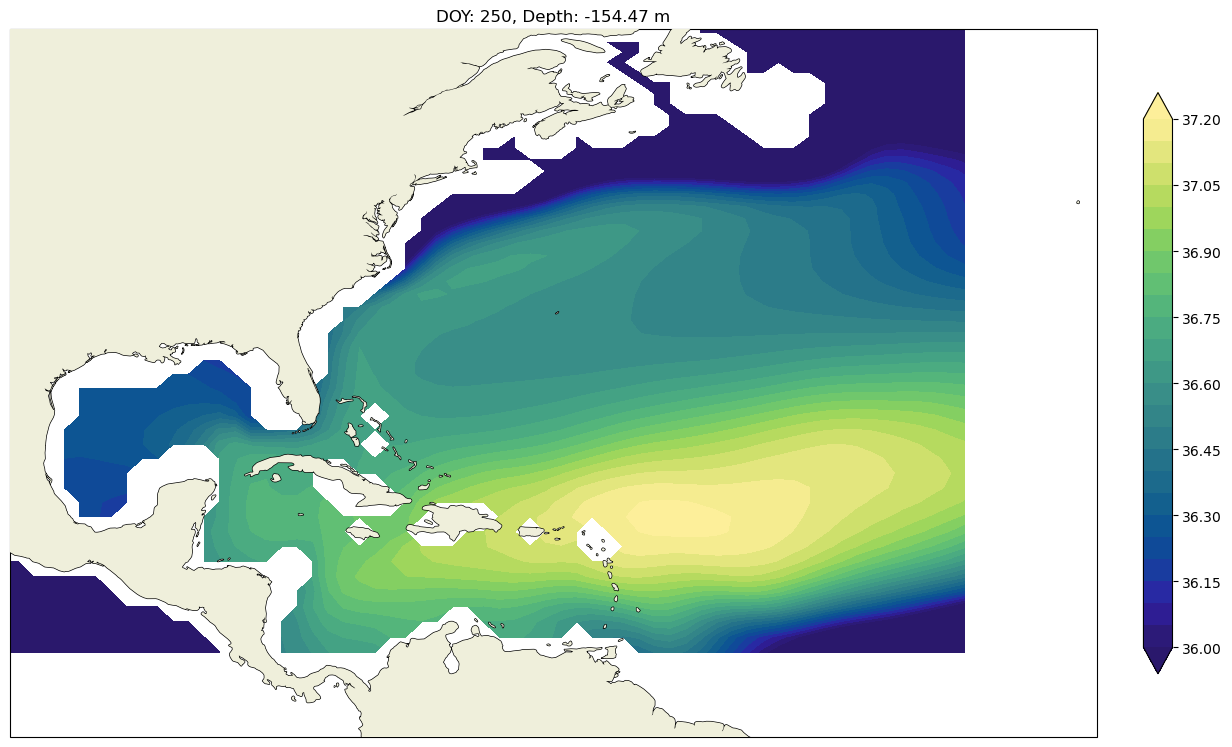

In [42]:
doy = 250
k=14

fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(ecco_grid.XC,ecco_grid.YC,daily_mean_ds.salt.isel(dayofyear=doy,k=k),levels=np.arange(36,37.2,0.05),extend='both',transform=cartopy.crs.PlateCarree(),cmap=cmo.haline)
fig.colorbar(im,fraction=0.025, pad=0.04)
#ax.set_ylim(10,35)
#ax.set_xlim(-100,-50)
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
ax.set_extent([-100, -30, 5, 45])
ax.set_title('DOY: %i, Depth: %s m'%(doy,ecco_grid.Z.isel(k=k).values))


Text(0.5, 1.0, 'DOY: 250, Depth: -95.095 m')

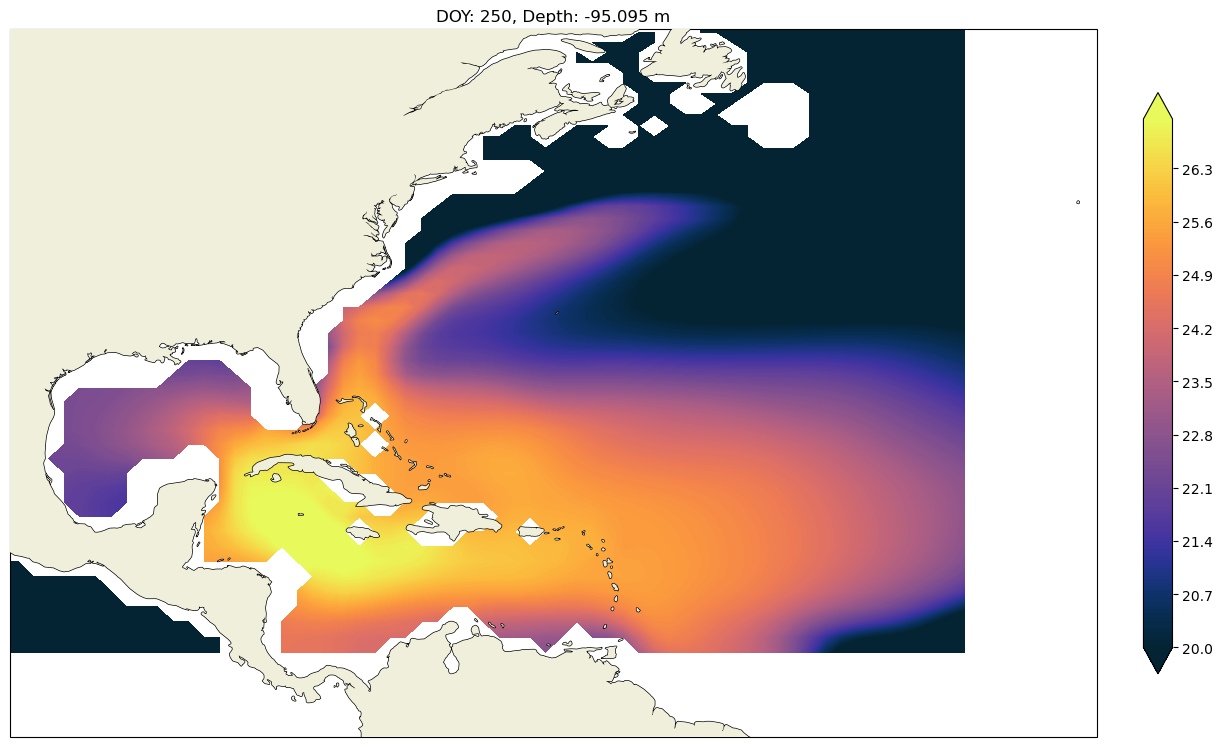

In [78]:
doy = 250
k=9

fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

im = ax.contourf(ecco_grid.XC,ecco_grid.YC,daily_mean_ds.temp.isel(dayofyear=doy,k=k),levels=np.arange(20,27,0.05),extend='both',transform=cartopy.crs.PlateCarree(),cmap=cmo.thermal)
fig.colorbar(im,fraction=0.025, pad=0.04)
#ax.set_ylim(10,35)
#ax.set_xlim(-100,-50)
ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
ax.set_extent([-100, -30, 5, 45])
ax.set_title('DOY: %i, Depth: %s m'%(doy,ecco_grid.Z.isel(k=k).values))


Text(0.5, 0, 'Day of Year')

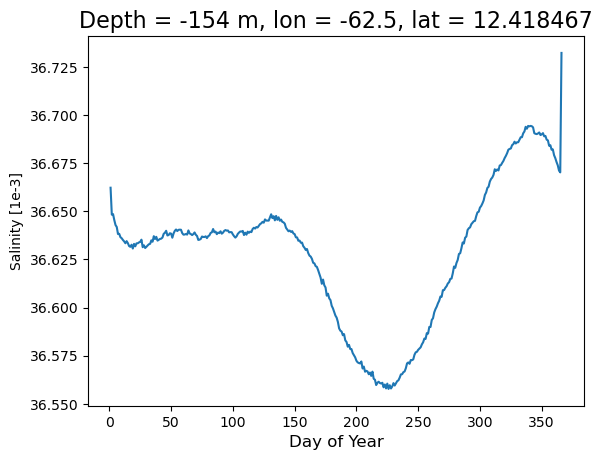

In [69]:
k=14
j = 65
i = 87

lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values


daily_mean_ds.salt.isel(k=k,i=i,j=j).plot()
plt.title('Depth = %i m, lon = %s, lat = %s'%(depth_val,lon_val,lat_val), fontsize=16)
plt.xlabel('Day of Year', fontsize=12)


Text(0.5, 1.0, 'Depth = -154 m, lon = [-62.5 -62.5], lat = [ 12.418467 -55.65936 ]')

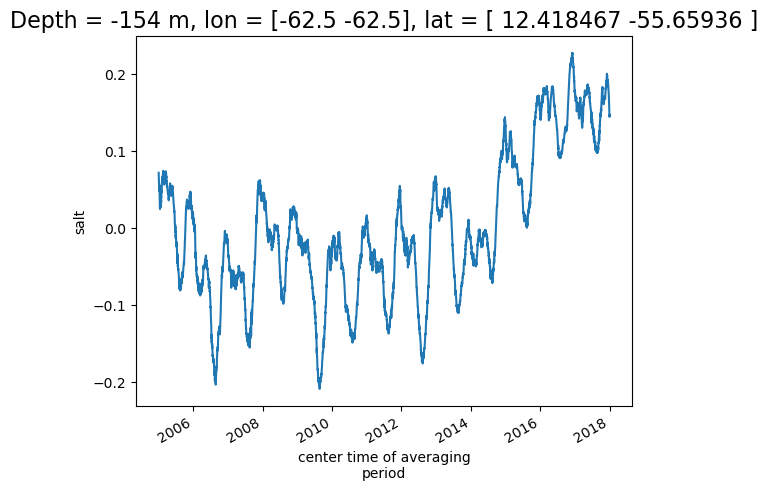

In [211]:
k=14
j = 65
i = 87

lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values


ds2.salt.isel(k=k,i=i,j=j,tile=0).plot()
plt.title('Depth = %i m, lon = %s, lat = %s'%(depth_val,lon_val,lat_val), fontsize=16)
#plt.xlabel('Day of Year', fontsize=12)


Text(0.5, 0, 'Day of Year')

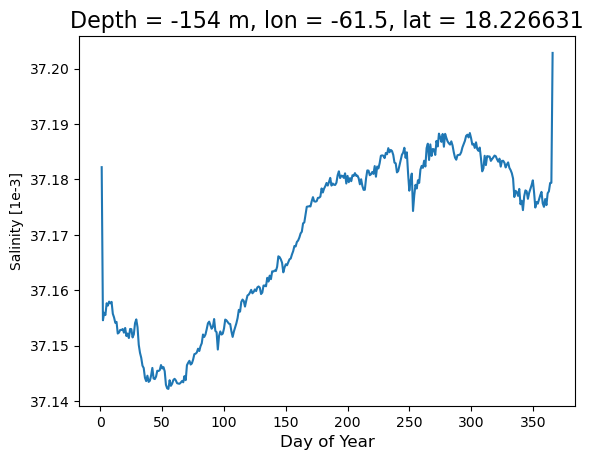

In [70]:
k=14
j = 66
i = 81

lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values


daily_mean_ds.salt.isel(k=k,i=i,j=j).plot()
plt.title('Depth = %i m, lon = %s, lat = %s'%(depth_val,lon_val,lat_val), fontsize=16)
plt.xlabel('Day of Year', fontsize=12)


In [37]:
# # Take volume-weighted mean of these terms
# tmp_a=(daily_mean_ds.G_total_TH*vol.isel(tile=10)).sum(dim=('k','i','j'))/vol.isel(tile=10).sum()
# tmp_b=(daily_mean_ds.G_advection_TH*vol.isel(tile=10)).sum(dim=('k','i','j'))/vol.isel(tile=10).sum()
# tmp_c=(daily_mean_ds.G_diffusion_TH*vol.isel(tile=10)).sum(dim=('k','i','j'))/vol.isel(tile=10).sum()
# tmp_d=(daily_mean_ds.G_forcing_TH*vol.isel(tile=10)).sum(dim=('k','i','j'))/vol.isel(tile=10).sum()

# # Sum of terms in RHS of equation
# rhs = daily_mean_ds.G_advection_TH + daily_mean_ds.G_diffusion_TH + daily_mean_ds.G_forcing_TH
# tmp_e=(rhs*vol.isel(tile=10)).sum(dim=('k','i','j'))/vol.isel(tile=10).sum()


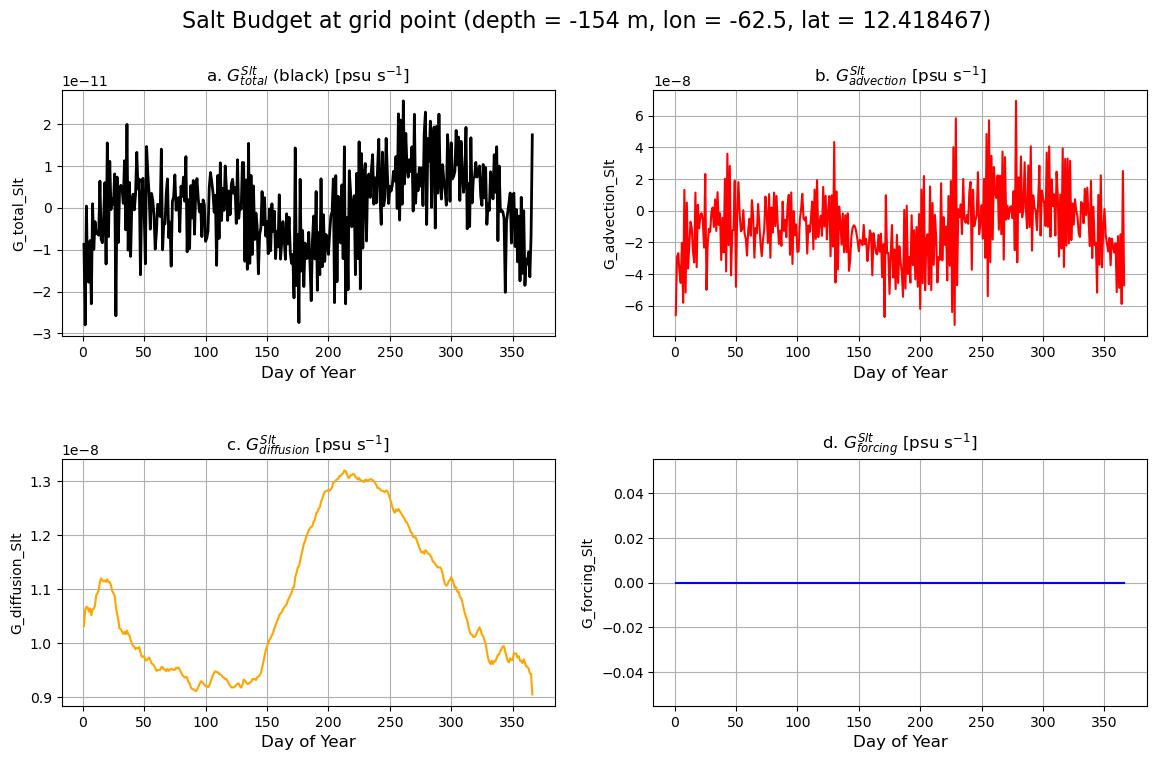

In [38]:
k=14
j = 65
i = 87


# compute vertical profiles at selected point and load into memory
G_total_Slt_atpt = daily_mean_ds.G_total_Slt.isel(j=j,i=i).compute()
G_advection_Slt_atpt = daily_mean_ds.G_advection_Slt.isel(j=j,i=i).compute()
G_diffusion_Slt_atpt = daily_mean_ds.G_diffusion_Slt.isel(j=j,i=i).compute()
G_forcing_Slt_atpt = daily_mean_ds.G_forcing_Slt.isel(j=j,i=i).compute()

rhs_atpt = G_advection_Slt_atpt + G_diffusion_Slt_atpt + G_forcing_Slt_atpt
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values








fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.sca(axs[0,0])
G_total_Slt_atpt.isel(k=k).plot(color='k',lw=2)
axs[0,0].set_title(r'a. $G^{Slt}_{total}$ (black) [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[0,1])
G_advection_Slt_atpt.isel(k=k).plot(color='r')
axs[0,1].set_title(r'b. $G^{Slt}_{advection}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,1].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,0])
G_diffusion_Slt_atpt.isel(k=k).plot(color='orange')
axs[1,0].set_title(r'c. $G^{Slt}_{diffusion}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,1])
G_forcing_Slt_atpt.isel(k=k).plot(color='b')
axs[1,1].set_title(r'd. $G^{Slt}_{forcing}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,1].set_xlabel('Day of Year', fontsize=12)
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Salt Budget at grid point (depth = %i m, lon = %s, lat = %s)'%(depth_val,lon_val,lat_val), fontsize=16)

plt.show()

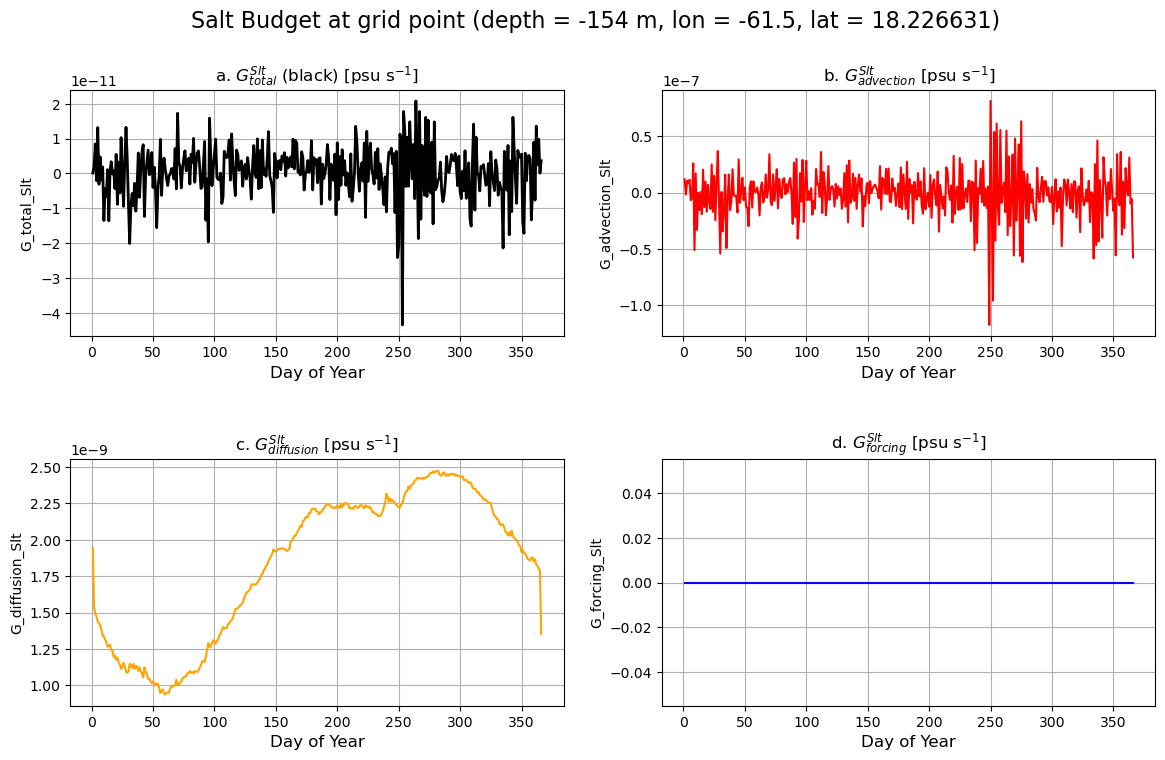

In [48]:
k=14
j = 66
i = 81


# compute vertical profiles at selected point and load into memory
G_total_Slt_atpt = daily_mean_ds.G_total_Slt.isel(j=j,i=i).compute()
G_advection_Slt_atpt = daily_mean_ds.G_advection_Slt.isel(j=j,i=i).compute()
G_diffusion_Slt_atpt = daily_mean_ds.G_diffusion_Slt.isel(j=j,i=i).compute()
G_forcing_Slt_atpt = daily_mean_ds.G_forcing_Slt.isel(j=j,i=i).compute()

rhs_atpt = G_advection_Slt_atpt + G_diffusion_Slt_atpt + G_forcing_Slt_atpt
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values








fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.sca(axs[0,0])
G_total_Slt_atpt.isel(k=k).plot(color='k',lw=2)
axs[0,0].set_title(r'a. $G^{Slt}_{total}$ (black) [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[0,1])
G_advection_Slt_atpt.isel(k=k).plot(color='r')
axs[0,1].set_title(r'b. $G^{Slt}_{advection}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,1].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,0])
G_diffusion_Slt_atpt.isel(k=k).plot(color='orange')
axs[1,0].set_title(r'c. $G^{Slt}_{diffusion}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,1])
G_forcing_Slt_atpt.isel(k=k).plot(color='b')
axs[1,1].set_title(r'd. $G^{Slt}_{forcing}$ [psu s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,1].set_xlabel('Day of Year', fontsize=12)
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Salt Budget at grid point (depth = %i m, lon = %s, lat = %s)'%(depth_val,lon_val,lat_val), fontsize=16)

plt.show()

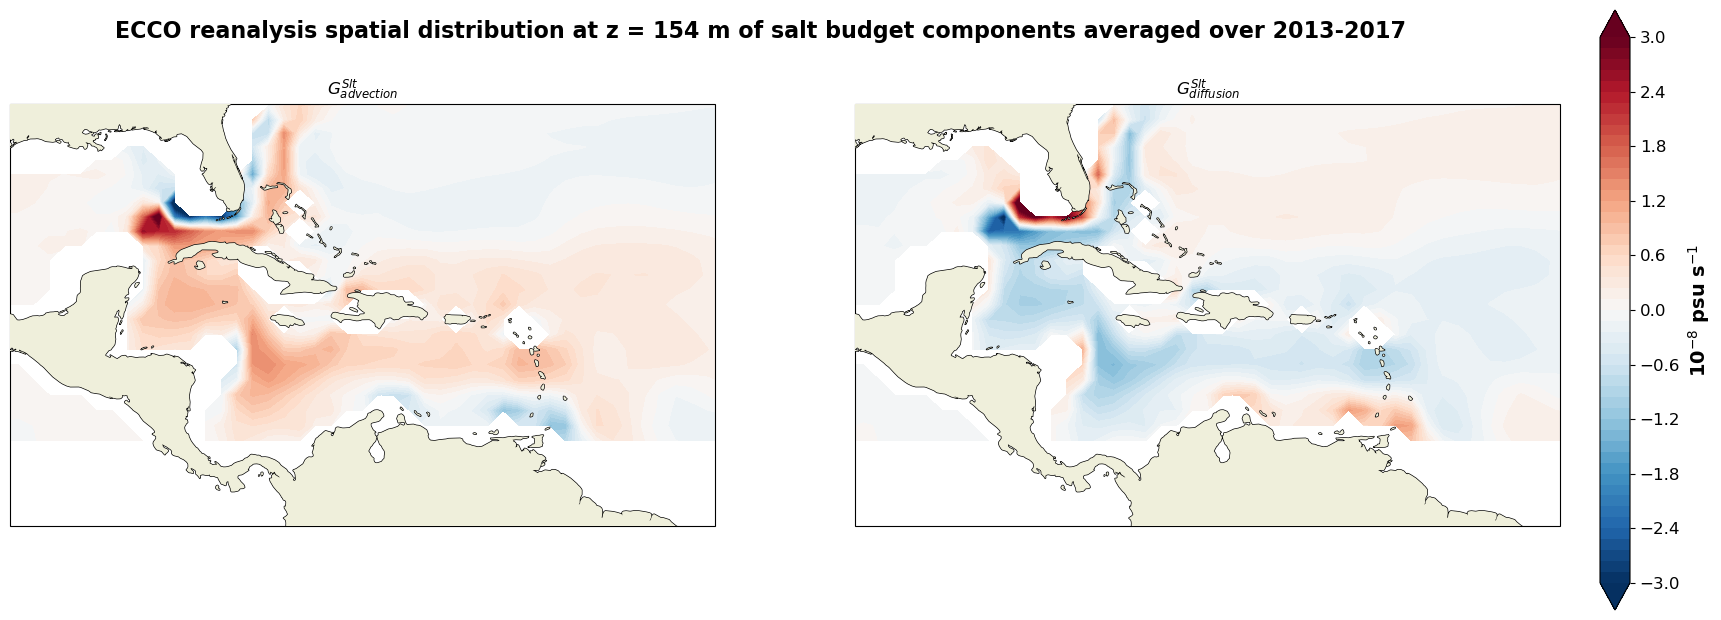

In [54]:
k=14


fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=2, subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

fig.suptitle('ECCO reanalysis spatial distribution at z = %i m of salt budget components averaged over 2013-2017'\
             %(np.round(-ecco_grid.Z[k].values)),
             fontsize=16, fontweight='bold',y=0.79)


########################################################################################################
ax[0].set_extent([-95, -50, 5, 30])
ax[0].coastlines(linewidth=1.0,zorder=10)
ax[0].add_feature(cartopy.feature.LAND,zorder=10)
ax[0].set_title(r'$G^{Slt}_{advection}$', fontsize=12)
im = ax[0].contourf(ecco_grid.XC,ecco_grid.YC, daily_mean_ds.G_advection_Slt.isel(k=k).mean(dim='dayofyear')*1e8, transform=cartopy.crs.PlateCarree(), 
                vmin=-3, vmax=3, cmap='RdBu_r', levels=np.linspace(-3, 3, 51), extend='both')
########################################################################################################


########################################################################################################
ax[1].set_extent([-95, -50, 5, 30])
ax[1].coastlines(linewidth=1.0,zorder=10)
ax[1].add_feature(cartopy.feature.LAND,zorder=10)
ax[1].set_title(r'$G^{Slt}_{diffusion}$', fontsize=12)
im = ax[1].contourf(ecco_grid.XC,ecco_grid.YC, daily_mean_ds.G_diffusion_Slt.isel(k=k).mean(dim='dayofyear')*1e8, transform=cartopy.crs.PlateCarree(), 
                vmin=-3, vmax=3, cmap='RdBu_r', levels=np.linspace(-3, 3, 51), extend='both')
########################################################################################################


cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cb = fig.colorbar(im, cax=cax, orientation='vertical',ticks=np.linspace(-3, 3, 11))
cb.ax.tick_params(labelsize=12)
cb.set_label(r'10$^{-8}$ psu s$^{-1}$', fontsize=14, fontweight='bold')



In [13]:
# fig, axs = plt.subplots(2, 2, figsize=(14,8))

# plt.sca(axs[0,0])
# tmp_a.plot(color='k',lw=2)
# tmp_e.plot(color='grey')
# axs[0,0].set_title(r'a. $G^\theta_{total}$ (black) / RHS (grey) [$^\circ$C s$^{-1}$]', fontsize=12)
# plt.grid()

# plt.sca(axs[0,1])
# tmp_b.plot(color='r')
# axs[0,1].set_title(r'b. $G^\theta_{advection}$ [$^\circ$C s$^{-1}$]', fontsize=12)
# plt.grid()

# plt.sca(axs[1,0])
# tmp_c.plot(color='orange')
# axs[1,0].set_title(r'c. $G^\theta_{diffusion}$ [$^\circ$C s$^{-1}$]', fontsize=12)
# plt.grid()

# plt.sca(axs[1,1])
# tmp_d.plot(color='b')
# axs[1,1].set_title(r'd. $G^\theta_{forcing}$ [$^\circ$C s$^{-1}$]', fontsize=12)
# plt.grid()
# plt.subplots_adjust(hspace = .5, wspace=.2)
# plt.suptitle('Global Heat Budget', fontsize=16);

In [79]:
## 20 lat, -81 lon is a good spot in the Cayman where there is the OHC peak

Text(0.5, 0, 'Day of Year')

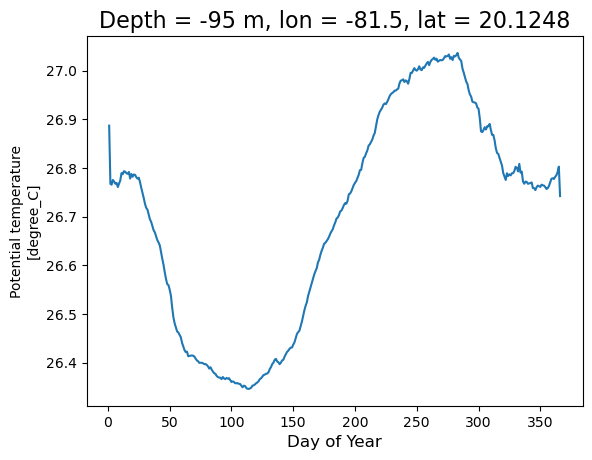

In [93]:
k=9
j = 46
i = 79

lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values


daily_mean_ds.temp.isel(k=k,i=i,j=j).plot()
plt.title('Depth = %i m, lon = %s, lat = %s'%(depth_val,lon_val,lat_val), fontsize=16)
plt.xlabel('Day of Year', fontsize=12)


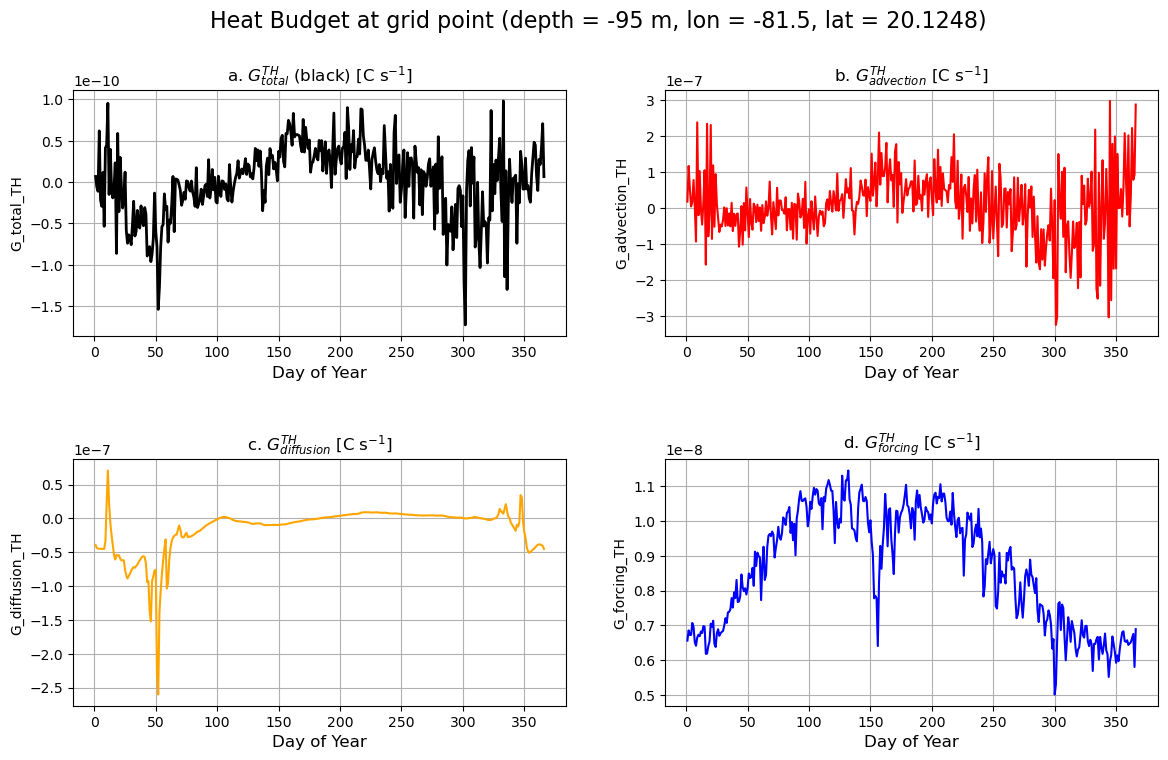

In [96]:
k=9
j = 46
i = 79


# compute vertical profiles at selected point and load into memory
G_total_TH_atpt = daily_mean_ds.G_total_TH.isel(j=j,i=i).compute()
G_advection_TH_atpt = daily_mean_ds.G_advection_TH.isel(j=j,i=i).compute()
G_diffusion_TH_atpt = daily_mean_ds.G_diffusion_TH.isel(j=j,i=i).compute()
G_forcing_TH_atpt = daily_mean_ds.G_forcing_TH.isel(j=j,i=i).compute()

rhs_atpt = G_advection_TH_atpt + G_diffusion_TH_atpt + G_forcing_TH_atpt
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values
depth_val = ecco_grid.Z.isel(k=k).values








fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.sca(axs[0,0])
G_total_TH_atpt.isel(k=k).plot(color='k',lw=2)
axs[0,0].set_title(r'a. $G^{TH}_{total}$ (black) [C s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[0,1])
G_advection_TH_atpt.isel(k=k).plot(color='r')
axs[0,1].set_title(r'b. $G^{TH}_{advection}$ [C s$^{-1}$]', fontsize=12)
plt.grid()
axs[0,1].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,0])
G_diffusion_TH_atpt.isel(k=k).plot(color='orange')
axs[1,0].set_title(r'c. $G^{TH}_{diffusion}$ [C s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,0].set_xlabel('Day of Year', fontsize=12)

plt.sca(axs[1,1])
G_forcing_TH_atpt.isel(k=k).plot(color='b')
axs[1,1].set_title(r'd. $G^{TH}_{forcing}$ [C s$^{-1}$]', fontsize=12)
plt.grid()
axs[1,1].set_xlabel('Day of Year', fontsize=12)
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Heat Budget at grid point (depth = %i m, lon = %s, lat = %s)'%(depth_val,lon_val,lat_val), fontsize=16)

plt.show()

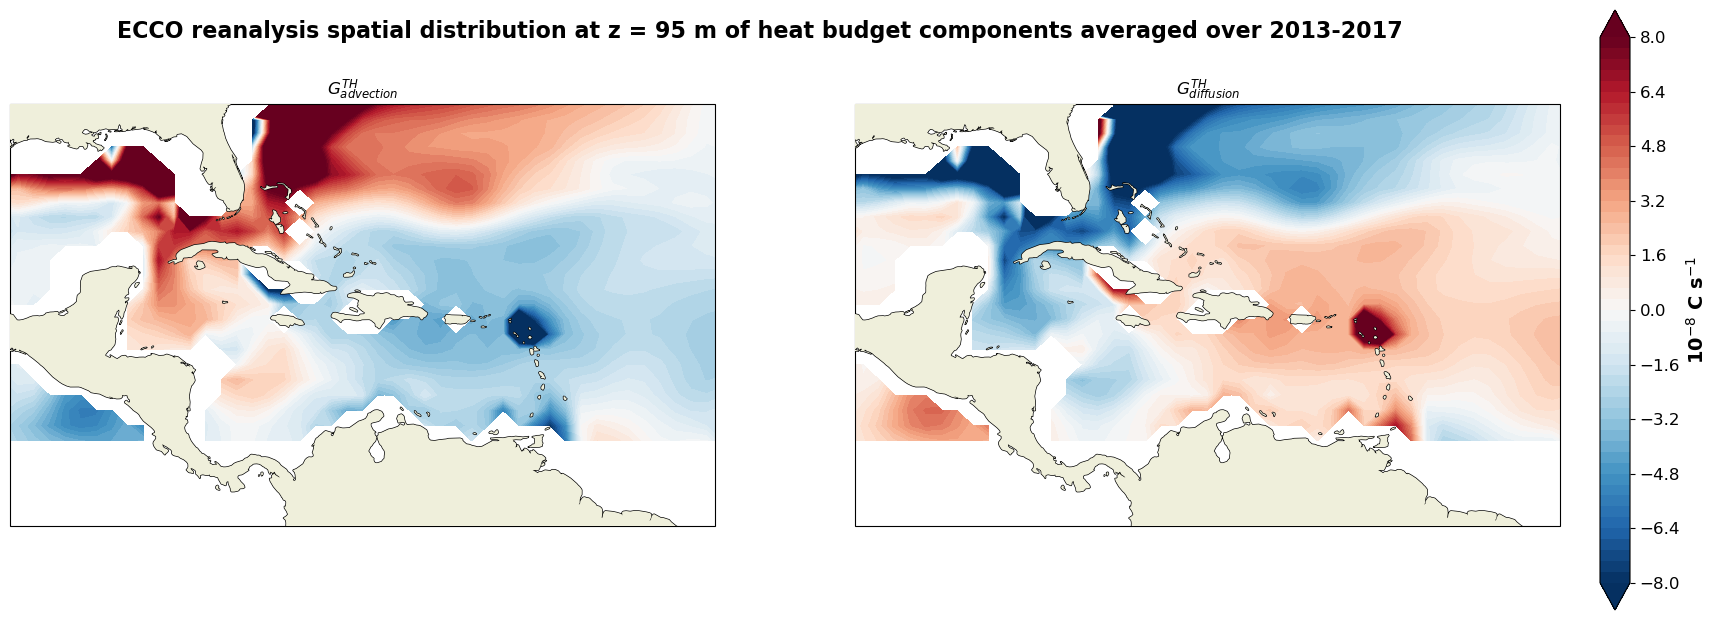

In [100]:
k=9


fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=2, subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

fig.suptitle('ECCO reanalysis spatial distribution at z = %i m of heat budget components averaged over 2013-2017'\
             %(np.round(-ecco_grid.Z[k].values)),
             fontsize=16, fontweight='bold',y=0.79)


########################################################################################################
ax[0].set_extent([-95, -50, 5, 30])
ax[0].coastlines(linewidth=1.0,zorder=10)
ax[0].add_feature(cartopy.feature.LAND,zorder=10)
ax[0].set_title(r'$G^{TH}_{advection}$', fontsize=12)
im = ax[0].contourf(ecco_grid.XC,ecco_grid.YC, daily_mean_ds.G_advection_TH.isel(k=k).mean(dim='dayofyear')*1e8, transform=cartopy.crs.PlateCarree(), 
                vmin=-8, vmax=8, cmap='RdBu_r', levels=np.linspace(-8, 8, 51), extend='both')
########################################################################################################


########################################################################################################
ax[1].set_extent([-95, -50, 5, 30])
ax[1].coastlines(linewidth=1.0,zorder=10)
ax[1].add_feature(cartopy.feature.LAND,zorder=10)
ax[1].set_title(r'$G^{TH}_{diffusion}$', fontsize=12)
im = ax[1].contourf(ecco_grid.XC,ecco_grid.YC, daily_mean_ds.G_diffusion_TH.isel(k=k).mean(dim='dayofyear')*1e8, transform=cartopy.crs.PlateCarree(), 
                vmin=-8, vmax=8, cmap='RdBu_r', levels=np.linspace(-8, 8, 51), extend='both')
########################################################################################################


cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cb = fig.colorbar(im, cax=cax, orientation='vertical',ticks=np.linspace(-8, 8, 11))
cb.ax.tick_params(labelsize=12)
cb.set_label(r'10$^{-8}$ C s$^{-1}$', fontsize=14, fontweight='bold')



Text(0.5, 0, 'Salinity [PSU]')

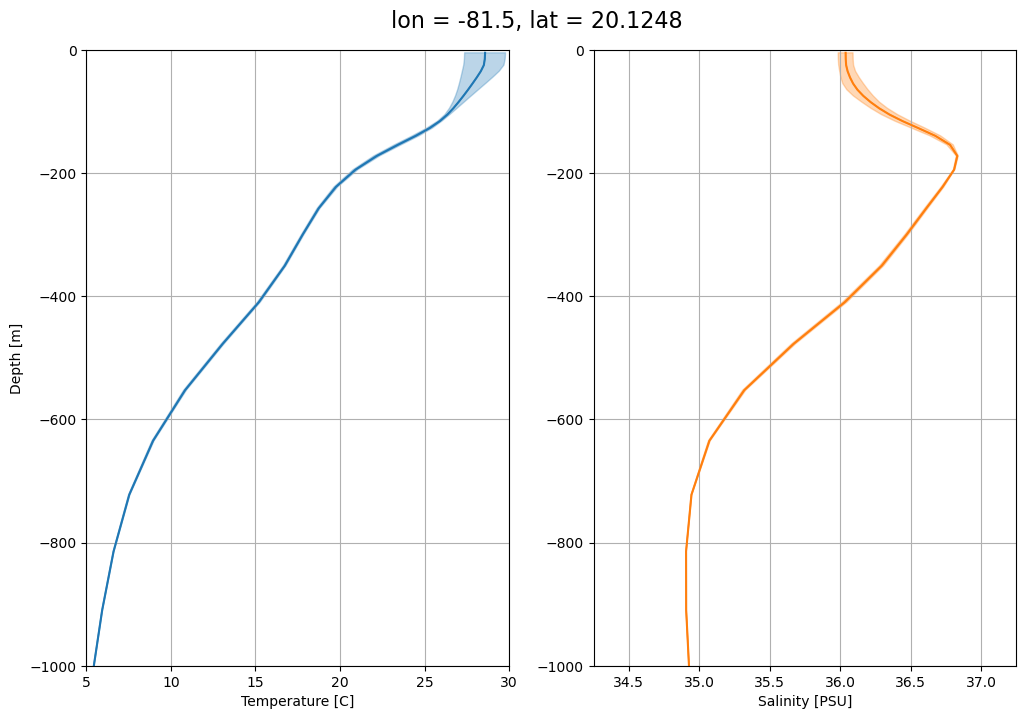

In [149]:
j = 46
i = 79
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values


fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2)

fig.suptitle('lon = %s, lat = %s'%(lon_val,lat_val), fontsize=16,y=0.93)
ax[0].plot(daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),ecco_grid.Z,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].grid()
ax[0].set_ylim(-1000,0)
ax[0].set_xlim(5,30)
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature [C]')

ax[1].plot(daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),ecco_grid.Z,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].grid()
ax[1].set_ylim(-1000,0)
ax[1].set_xlim(34.25,37.25)
ax[1].set_xlabel('Salinity [PSU]')


Text(0.5, 0, 'Salinity [PSU]')

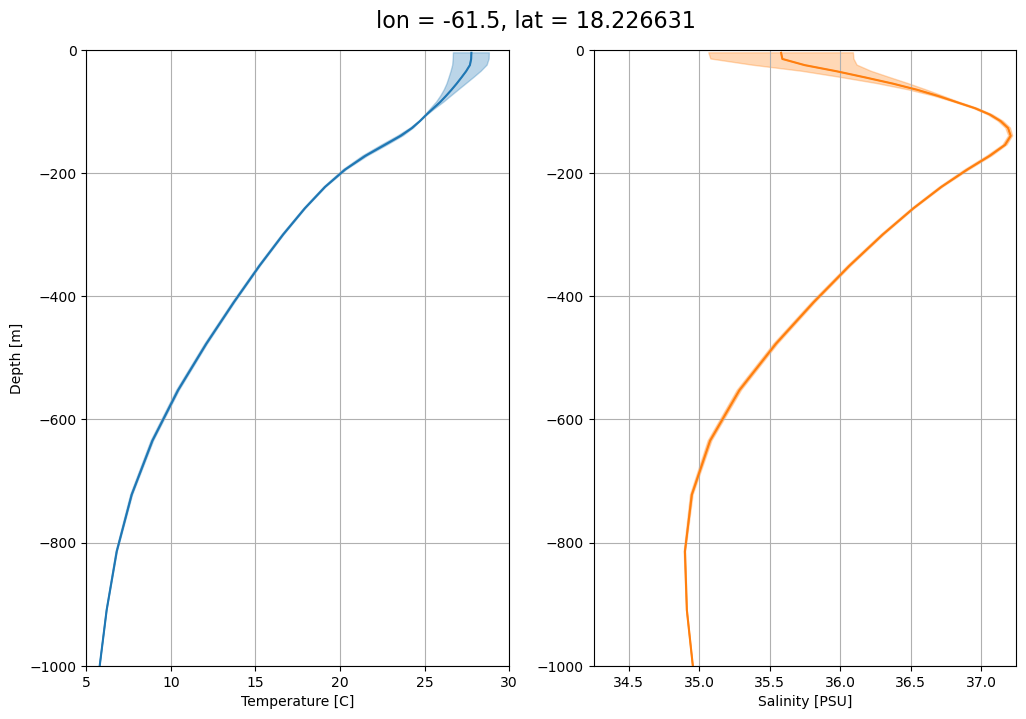

In [150]:
j = 66
i = 81
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2)

fig.suptitle('lon = %s, lat = %s'%(lon_val,lat_val), fontsize=16,y=0.93)
ax[0].plot(daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),ecco_grid.Z,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].grid()
ax[0].set_ylim(-1000,0)
ax[0].set_xlim(5,30)
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature [C]')

ax[1].plot(daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),ecco_grid.Z,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].grid()
ax[1].set_ylim(-1000,0)
ax[1].set_xlim(34.25,37.25)
ax[1].set_xlabel('Salinity [PSU]')



Text(0.5, 0, 'Salinity [PSU]')

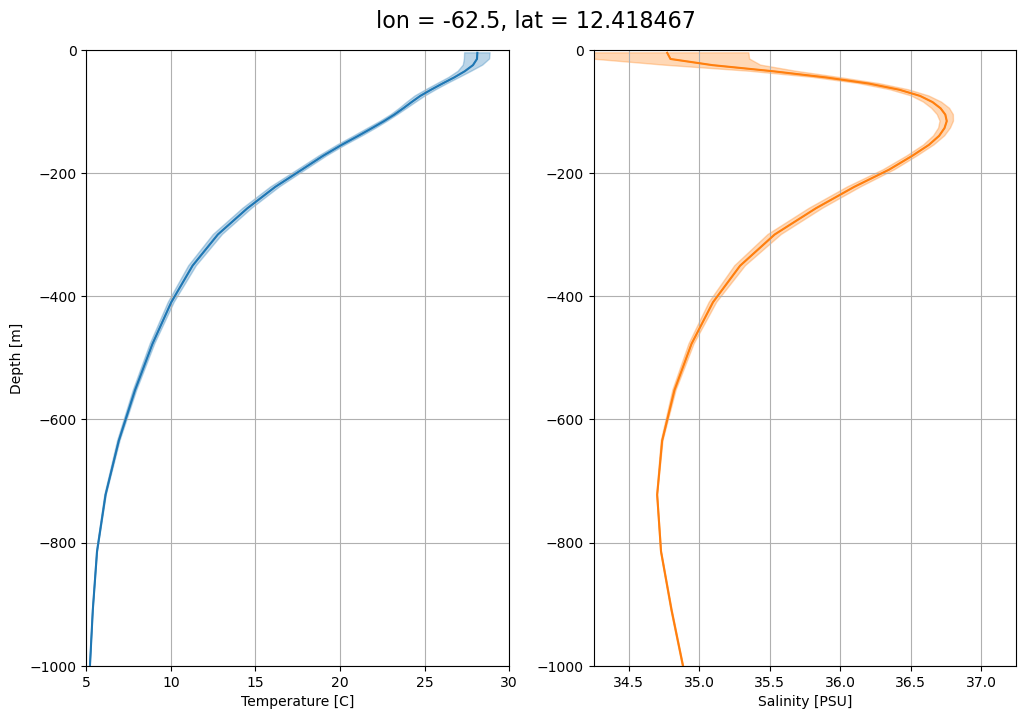

In [151]:
j = 65
i = 87
lon_val = ecco_grid.XC.isel(i=i,j=j).values
lat_val = ecco_grid.YC.isel(i=i,j=j).values

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2)

fig.suptitle('lon = %s, lat = %s'%(lon_val,lat_val), fontsize=16,y=0.93)
ax[0].plot(daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),ecco_grid.Z,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).temp.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).temp.std(dim='dayofyear'),alpha=0.3,color='tab:blue')
ax[0].grid()
ax[0].set_ylim(-1000,0)
ax[0].set_xlim(5,30)
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature [C]')

ax[1].plot(daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),ecco_grid.Z,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')+daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].fill_betweenx(ecco_grid.Z,daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear'),daily_mean_ds.isel(i=i,j=j).salt.mean(dim='dayofyear')-daily_mean_ds.isel(i=i,j=j).salt.std(dim='dayofyear'),alpha=0.3,color='tab:orange')
ax[1].grid()
ax[1].set_ylim(-1000,0)
ax[1].set_xlim(34.25,37.25)
ax[1].set_xlabel('Salinity [PSU]')



In [204]:
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Generate example daily data
np.random.seed(0)
num_days = 365
daily_data = np.random.randn(num_days)

# Define the cutoff frequencies for the bandpass filter
lowcut = 1.0 / 40  # 40 days
highcut = 1.0 / 30  # 30 days

# Function to create a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply Butterworth filter with initial condition preserved
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a, order)
    y, _ = lfilter(b, a, data, zi=zi*data[0])
    return y

# Function to calculate initial condition for lfilter
def lfilter_zi(b, a, order):
    zi = np.zeros(order)
    return zi

# Sample rate (daily resolution)
fs = 1.0  # 1 sample per day


# Apply bandpass filter
filtered_data = butter_bandpass_filter(daily_mean_ds.salt.isel(i=50,j=60,k=0).values, lowcut, highcut, fs, order=5)

# Plot original and filtered data
plt.figure(figsize=(10, 6))
plt.plot(daily_mean_ds.dayofyear.values, daily_mean_ds.salt.isel(i=50,j=60,k=0).values, label='Original Data')
plt.plot(daily_mean_ds.dayofyear.values, filtered_data, label='Filtered Data (30-40 days)')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Original and Filtered Data')
plt.legend()
plt.grid(True)
plt.show()


ValueError: Unexpected shape for zi: expected (10,), found (5,).

In [202]:
butter_bandpass_filter(test, lowcut, highcut, fs, order=5)

UnboundLocalError: cannot access local variable 'zi' where it is not associated with a value

In [201]:
test = daily_mean_ds.salt.isel(i=50,j=60,k=0).values
global test

In [232]:
ds.SALT_snp.isel(time_snp=0,k=0,tile=[1,2,10,11])


<xarray.DataArray 'SALT_snp' (tile: 4, j: 90, i: 90)>
dask.array<getitem, shape=(4, 90, 90), dtype=float32, chunksize=(4, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i         (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile      (tile) int32 1 2 10 11
    time_snp  datetime64[ns] 2013-01-01T12:00:00
    k         int32 0
Attributes:
    long_name:              Salinity
    units:                  1e-3
    coverage_content_type:  modelResult
    standard_name:          sea_water_salinity
    valid_min:              16.73577880859375
    valid_max:              41.321231842041016
    comment:                Defined using CF convention 'Sea water salinity i...

ValueError: Mismatch between geometry and dataset

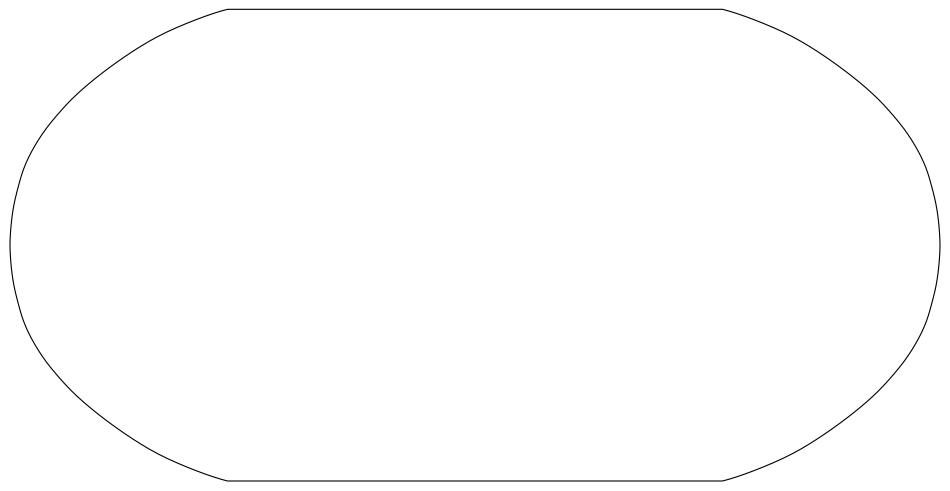

In [231]:
ds.SALT_snp.isel(time_snp=0,k=0,tile=[1,2,10,11])


plt.figure(num=0,figsize=(12,10))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC.values,\
                              ecco_grid.YC.values,\
                              ds.SALT_snp.isel(time_snp=0,k=0,tile=[1,2,10,11]))
plt.title('Mean ECCOv4r4 SSH in the year 2000')
plt.show()

In [ ]:
ecco_podaac_download_subset


include_latlon_coords = False, tile_isel=[1,2,10,11]